## Import Library

In [1]:
!pip install split-folders
!pip install tensorflowjs

import zipfile
import os
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import splitfolders
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TFSMLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from google.colab import files

## Data Preparation

In [2]:
local_zip = 'Shoe vs Sandal vs Boot Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

### Data Loading

In [3]:
base_dir = '/tmp/Shoe vs Sandal vs Boot Dataset'
shutil.rmtree('/tmp/Shoe vs Sandal vs Boot Dataset/rps-cv-images',ignore_errors=True)
splitfolders.ratio(base_dir, output=base_dir, ratio=(.8,.2))
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 15000 files [00:03, 3960.80 files/s]


In [4]:
os.listdir(train_dir)

['Boot', 'val', 'Sandal', 'train', 'Shoe']

In [5]:
os.listdir(validation_dir)

['Boot', 'val', 'Sandal', 'train', 'Shoe']

In [6]:
import os
import cv2
from collections import defaultdict

train_dir = '/tmp/Shoe vs Sandal vs Boot Dataset/train'

image_shapes = defaultdict(list)

for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                shape = img.shape[:2]
                image_shapes[category].append(shape)

for category, shapes in image_shapes.items():
    print(f"{category}: {len(shapes)}")
    unique_shapes = set(shapes)
    for shape in unique_shapes:
        print(f" - {shape}")
    print("—" * 30)


Boot: 4000
 - (102, 136)
——————————————————————————————
Sandal: 4000
 - (102, 135)
 - (102, 136)
——————————————————————————————
Shoe: 4000
 - (102, 136)
——————————————————————————————


### Data Preprocessing

In [7]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2
                    )

#### Split Dataset

In [8]:
train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        classes=['Sandal', 'Shoe', 'Boot'],
        subset='training',

)

Found 12000 images belonging to 3 classes.


In [9]:
valid_generator = test_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        classes=['Sandal', 'Shoe', 'Boot'],
        subset='validation',

)

Found 3000 images belonging to 3 classes.


## Modelling

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,530,691 (51.62 MB)

 Trainable params: 13,530,691 (51.62 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90:
            print("\nAkurasi dan validasi akurasi telah mencapai >= 90%!")
            self.model.stop_training = True

callbacks = myCallback()

In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = 32,
    epochs = 50,
    validation_data = valid_generator,
    verbose=2,
    callbacks=[callbacks]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 - 91s - 3s/step - accuracy: 0.3965 - loss: 1.4725 - val_accuracy: 0.6067 - val_loss: 1.0683
Epoch 2/50
32/32 - 80s - 2s/step - accuracy: 0.6211 - loss: 1.0014 - val_accuracy: 0.6947 - val_loss: 0.9059
Epoch 3/50
32/32 - 87s - 3s/step - accuracy: 0.7227 - loss: 0.7778 - val_accuracy: 0.7940 - val_loss: 0.6092
Epoch 4/50
32/32 - 81s - 3s/step - accuracy: 0.7627 - loss: 0.7000 - val_accuracy: 0.8520 - val_loss: 0.5252
Epoch 5/50
32/32 - 86s - 3s/step - accuracy: 0.8018 - loss: 0.6231 - val_accuracy: 0.8857 - val_loss: 0.4705
Epoch 6/50
32/32 - 80s - 2s/step - accuracy: 0.8115 - loss: 0.5874 - val_accuracy: 0.8817 - val_loss: 0.4367
Epoch 7/50
32/32 - 80s - 3s/step - accuracy: 0.8398 - loss: 0.5326 - val_accuracy: 0.9233 - val_loss: 0.3419
Epoch 8/50
32/32 - 78s - 2s/step - accuracy: 0.8789 - loss: 0.4855 - val_accuracy: 0.8743 - val_loss: 0.4712
Epoch 9/50
32/32 - 82s - 3s/step - accuracy: 0.8691 - loss: 0.4913 - val_accuracy: 0.9220 - val_loss: 0.3451
Epoch 10/50
32/32 -

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Akurasi dan validasi akurasi telah mencapai >= 90%!
32/32 - 67s - 2s/step - accuracy: 0.9008 - loss: 0.3974 - val_accuracy: 0.9273 - val_loss: 0.3238


## Evaluasi dan Visualisasi

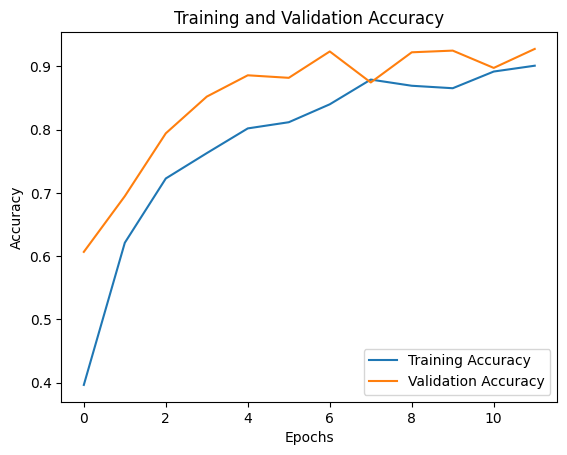

In [15]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

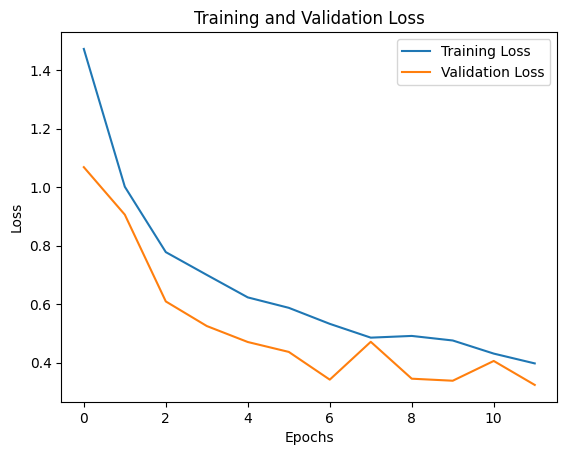

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [17]:
# Mengonversi model ke format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [18]:
# Mengonversi model ke format TFlite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

11968

In [19]:
# Mengonversi model ke format TFJS
tfjs.converters.save_keras_model(model, 'model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference

In [20]:
# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="vegs.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

Saving boot (3).jpg to boot (3).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
boot (3).jpg
Boot


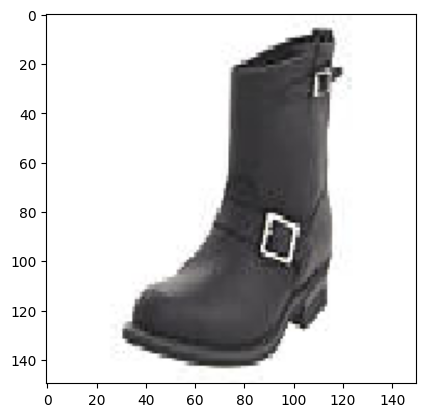

In [25]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150,150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

classes = model.predict(images, batch_size=10)
print(fn)
if classes[0][0]==1:
    print('Sandal')
elif classes[0][1]==1:
    print('Shoe')
else:
    print('Boot')